In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import yfinance as yf

df = yf.download("BTC-USD", start="2018-01-01", end="2025-01-01")


/tmp/ipython-input-3876399577.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("BTC-USD", start="2018-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


In [3]:
import pandas as pd 
import numpy as np

In [4]:
df=pd.read_csv("C:\\Users\\bachiler\\Desktop\\time series\\bitcoin_data.csv")

In [5]:
df["Date"]=pd.to_datetime(df["Date"])
df.drop(df[df['Date']<'2021-01-01'].index,inplace=True)
df.set_index('Date', inplace=True)
df.head()

,Unnamed: 0,Close,High,Low,Open,Volume
Date,,,,,,
2021-01-01,1098,29374.152344,29600.626953,28803.585938,28994.009766,40730301359
2021-01-02,1099,32127.267578,33155.117188,29091.181641,29376.455078,67865420765
2021-01-03,1100,32782.023438,34608.558594,32052.316406,32129.408203,78665235202
2021-01-04,1101,31971.914062,33440.218750,28722.755859,32810.949219,81163475344
2021-01-05,1102,33992.429688,34437.589844,30221.187500,31977.041016,67547324782


In [6]:
df = df.sort_index()
df = df.asfreq("1D")   # or '1H', '1min' depending on your data

low = float(df['Close'].quantile(0.001))
high = float(df['Close'].quantile(0.999))

df['Close'] = df['Close'].clip(lower=low, upper=high)


In [7]:
df_prophet = df[['Close']].copy()
df_prophet['ds'] = df.index
df_prophet['y'] = df_prophet['Close']

df_prophet = df_prophet[['ds', 'y']]


In [8]:
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])


In [9]:
low = float(df_prophet['y'].quantile(0.001))
high = float(df_prophet['y'].quantile(0.999))
df_prophet['y'] = df_prophet['y'].clip(lower=low, upper=high)


In [10]:
from prophet import Prophet

model = Prophet(daily_seasonality=True)
model.fit(df_prophet)


C:\Users\bachiler\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
22:10:29 - cmdstanpy - INFO - Chain [1] start processing
22:10:32 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
future = model.make_future_dataframe(periods=30)  # predict 30 days
forecast = model.predict(future)


In [15]:
df_reg = df.copy()

df_reg['ds'] = df_reg.index
df_reg['y'] = df_reg['Close']

df_reg['range'] = df_reg['High'] - df_reg['Low']
df_reg['return'] = df_reg['Close'].pct_change()
df_reg['volume_ma'] = df_reg['Volume'].rolling(5).mean()

df_reg = df_reg[['ds', 'y', 'range', 'return', 'volume_ma']]
df_reg = df_reg.dropna()
df_reg = df_reg.set_index("ds").asfreq("D")

In [16]:
from prophet import Prophet

model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.2,   # increase flexibility
    seasonality_prior_scale=15,    # stronger seasonality
    changepoint_range=0.95         # allow more breakpoints
)


In [17]:
model.add_regressor('range')
model.add_regressor('return')
model.add_regressor('volume_ma')
model.fit(df_reg)
future = model.make_future_dataframe(periods=30)

# add regressors to future from last known values
future['range'] = df_reg['range'].iloc[-1]
future['return'] = df_reg['return'].iloc[-1]
future['volume_ma'] = df_reg['volume_ma'].iloc[-1]

forecast = model.predict(future)
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(df_reg['ds'], df_reg['y'], label='Actual Price')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)
plt.legend()
plt.title("Prophet Forecast With Extra Regressors (Crypto)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [18]:
df_reg = df.copy()

# Required columns
df_reg['ds'] = df_reg.index
df_reg['y'] = df_reg['Close']
df_reg['range'] = df_reg['High'] - df_reg['Low']
df_reg['return'] = df_reg['Close'].pct_change()
df_reg['volume_ma'] = df_reg['Volume'].rolling(5).mean()
df_reg['y'] = df_reg['y'].interpolate()
df_reg['range'] = df_reg['range'].interpolate()
df_reg['return'] = df_reg['return'].interpolate()
df_reg['volume_ma'] = df_reg['volume_ma'].interpolate()
df_reg = df_reg[['ds', 'y', 'range', 'return', 'volume_ma']]
df_reg['ds'] = pd.to_datetime(df_reg['ds'])
df_reg = df_reg.set_index('ds').asfreq('D')
df_reg = df_reg.reset_index()
print(df_reg.columns)


Index(['ds', 'y', 'range', 'return', 'volume_ma'], dtype='object')


In [19]:
df_reg['y'] = df_reg['y'].interpolate()
df_reg['range'] = df_reg['range'].interpolate()
df_reg['return'] = df_reg['return'].interpolate()
df_reg['volume_ma'] = df_reg['volume_ma'].interpolate()


In [20]:
df_reg['return'] = df_reg['return'].fillna(0)
df_reg['range'] = df_reg['range'].fillna(df_reg['range'].median())
df_reg['volume_ma'] = df_reg['volume_ma'].fillna(df_reg['volume_ma'].median())
df_reg['y'] = df_reg['y'].fillna(method='ffill')


C:\Users\bachiler\AppData\Local\Temp\ipykernel_13292\2402895741.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_reg['y'] = df_reg['y'].fillna(method='ffill')


In [21]:
from prophet import Prophet

model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.2,
    seasonality_prior_scale=15,
    changepoint_range=0.95
)

model.add_regressor('range')
model.add_regressor('return')
model.add_regressor('volume_ma')

model.fit(df_reg)


22:11:59 - cmdstanpy - INFO - Chain [1] start processing
22:12:01 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
future = model.make_future_dataframe(periods=30)

# Use last known values for regressors
future['range'] = df_reg['range'].iloc[-1]
future['return'] = df_reg['return'].iloc[-1]
future['volume_ma'] = df_reg['volume_ma'].iloc[-1]


In [23]:
forecast = model.predict(future)


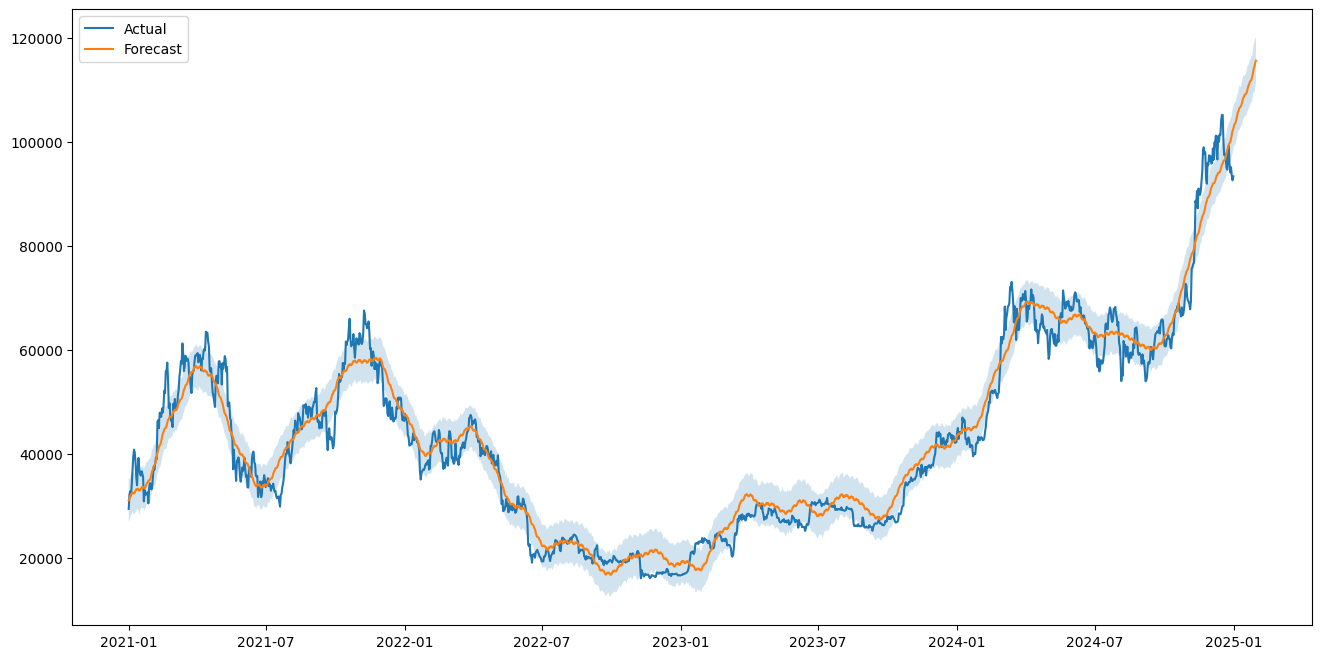

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(df_reg['ds'], df_reg['y'], label="Actual")
plt.plot(forecast['ds'], forecast['yhat'], label="Forecast")
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)
plt.legend()
plt.show()


In [29]:
def mape(actual,pred):
    actual,pred=np.array(actual),np.array(pred)
    mape=np.mean(np.abs((actual-pred[:-30])/actual))*100
    return mape

In [30]:
mape=mape(df_reg['y'],forecast['yhat'])

In [35]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(df_reg['y'],forecast['yhat'][:-30])
error=np.sqrt(mse)

In [37]:
print("rmse "f"{error}")
print("mape "f"{mape}")
#print(y)

rmse 3605.818342324086
mape 7.56302578621538
